# **Configuration du dataset RSCID**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_json = "/content/drive/MyDrive/Classroom/MSV/dataset RSICD/dataset_rsicd.json"
path_img_folder = "/content/drive/MyDrive/Classroom/MSV/dataset RSICD/images"

In [5]:
import json

# Charger le fichier JSON
with open(path_json, 'r') as file:
    data = json.load(file)

# Création du dataset
dataset_map = {}
for item in data["images"]:
    filename = "/content/drive/MyDrive/Classroom/MSV/dataset RSICD/images/" + item['filename']
    captions = [sent['raw'] for sent in item['sentences']]
    dataset_map[filename] = captions

In [6]:
# Afficher un exemple
ex = "/content/drive/MyDrive/Classroom/MSV/dataset RSICD/images/airport_10.jpg"
if ex in dataset_map:
    print("Image path :", ex)
    print("Labels :")
    print(dataset_map[ex])

Image path : /content/drive/MyDrive/Classroom/MSV/dataset RSICD/images/airport_10.jpg
Labels :
['some planes are parked in an airport .', 'the airport here is full of airplanes and containers .', 'the airport here is full of airplanes and containers .', 'some planes are parked in an airport .', 'some planes are parked in an airport .']


In [7]:
print(len(dataset_map))

10921


# **Segmentation du dataset**

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 64.1 MB/s eta 0:00:00


In [9]:
# Charger le modèle pré-entrainé
model = torch.load('/content/drive/MyDrive/Classroom/MSV/Production/Unet-Mobilenet-v3.pt')

In [10]:
class DatasetRSCID(Dataset):

    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            aug = self.transform(image=img)
            img = Image.fromarray(aug['image'])

        if self.transform is None:
            img = Image.fromarray(img)

        return img

In [11]:
import torch
from torchvision import transforms as T

# Define class groups based on the provided classes
class_groups = [
    [0],  # 'unlabeled'
    [1, 9],  # 'paved-area', 'roof'
    [2, 4, 6],  # 'dirt', 'gravel', 'rocks'
    [5, 7],  # 'water', 'pool'
    [3, 8, 19, 20],  # 'grass', 'vegetation', 'tree', 'bald-tree'
    [10, 11, 12],  # 'wall', 'window', 'door'
    [13, 14],  # 'fence', 'fence-pole'
    [15, 16],  # 'person', 'dog'
    [17, 18],  # 'car', 'bicycle'
    [21, 22]  # 'ar-marker', 'obstacle'
]

group_names = [
    'Unlabeled',
    'Artificial Surface',
    'Natural Surface',
    'Water',
    'Vegetation',
    'Building',
    'Fences & Poles',
    'People & Animals',
    'Vehicles',
    'Markers & Obstacles'
]

# Create a mapping from original class to group index
class_to_group = {}
for group_idx, group in enumerate(class_groups):
    for class_id in group:
        class_to_group[class_id] = group_idx

def predict_image_mask_miou(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image = image.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)

    # Remap the original class predictions to group indices
    remapped_masked = masked.clone()
    for original_class, group_idx in class_to_group.items():
        remapped_masked[masked == original_class] = group_idx

    return remapped_masked

In [12]:
filenames = list(dataset_map.keys())
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DatasetRSCID(filenames, transform=t_test)
print(test_set.img_paths)

['/content/drive/MyDrive/Classroom/MSV/dataset RSICD/images/airport_1.jpg', '/content/drive/MyDrive/Classroom/MSV/dataset RSICD/images/airport_10.jpg', '/content/drive/MyDrive/Classroom/MSV/dataset RSICD/images/airport_100.jpg', '/content/drive/MyDrive/Classroom/MSV/dataset RSICD/images/airport_101.jpg', '/content/drive/MyDrive/Classroom/MSV/dataset RSICD/images/airport_102.jpg', '/content/drive/MyDrive/Classroom/MSV/dataset RSICD/images/airport_103.jpg', '/content/drive/MyDrive/Classroom/MSV/dataset RSICD/images/airport_104.jpg', '/content/drive/MyDrive/Classroom/MSV/dataset RSICD/images/airport_105.jpg', '/content/drive/MyDrive/Classroom/MSV/dataset RSICD/images/airport_106.jpg', '/content/drive/MyDrive/Classroom/MSV/dataset RSICD/images/airport_107.jpg', '/content/drive/MyDrive/Classroom/MSV/dataset RSICD/images/airport_108.jpg', '/content/drive/MyDrive/Classroom/MSV/dataset RSICD/images/airport_109.jpg', '/content/drive/MyDrive/Classroom/MSV/dataset RSICD/images/airport_11.jpg', '/

In [16]:
import os
import numpy as np
import cv2

i = 10920

for tmp in test_set:
    # Prédiction du mask de la segmentation
    pred_mask = predict_image_mask_miou(model, tmp)
    mask_array = np.array(pred_mask)

    values = np.unique(mask_array)
    perc = {}
    cents = {}
    txt = ""

    # Calcul du pourcentage et du centre de la classe
    for v in values:
      tmp_points = np.argwhere(mask_array == v)
      nb_occ = len(tmp_points)
      p = (nb_occ / mask_array.size) * 100
      perc[v] = p
      (x, y), radius = cv2.minEnclosingCircle(tmp_points.astype(np.float32))
      cents[v] = (int(x), int(y))
      txt += f"{v};{p:.2f};{cents[v]}"
      txt += "\n"

    # Enregistrement des données
    file_path = filenames[i]
    pred_name_file = file_path.split("/")[-1]
    pred_name_file = pred_name_file.split(".")[0]
    pred_path = os.path.join("/content/drive/MyDrive/Classroom/MSV/dataset RSICD/segmentation_unet_mobiletnet/", pred_name_file + ".txt")

    with open(pred_path, "w") as f:
      f.write(txt)

    i += 1
    print("Save pred - ", i, " : ", pred_name_file, "OK")

Save pred -  10920  :  00921 OK


# **Affichage d'un résultat**

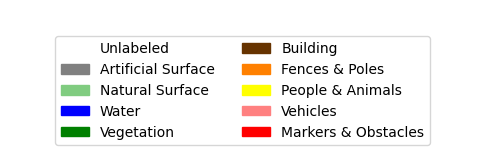

In [56]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

specific_colors = {
    'Unlabeled': (255, 255, 255),       # blanc
    'Artificial Surface': (128, 128, 128),  # gris
    'Natural Surface': (128, 204, 128),  # vert clair
    'Water': (0, 0, 255),               # bleu
    'Vegetation': (0, 128, 0),          # vert foncé
    'Building': (102, 51, 0),           # marron
    'Fences & Poles': (255, 128, 0),    # orange
    'People & Animals': (255, 255, 0),  # jaune
    'Vehicles': (255, 128, 128),        # rose
    'Markers & Obstacles': (255, 0, 0)  # rouge
}

specific_colors_normalized = {key: tuple(val / 255 for val in value) for key, value in specific_colors.items()}
group_names = list(specific_colors_normalized.keys())
cmap = mcolors.ListedColormap(list(specific_colors_normalized.values()), name='custom_cmap')

legend_patches = [Patch(color=color, label=group) for group, color in specific_colors_normalized.items()]
plt.figure(figsize=(6, 1))
plt.legend(handles=legend_patches, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.axis('off')
plt.show()

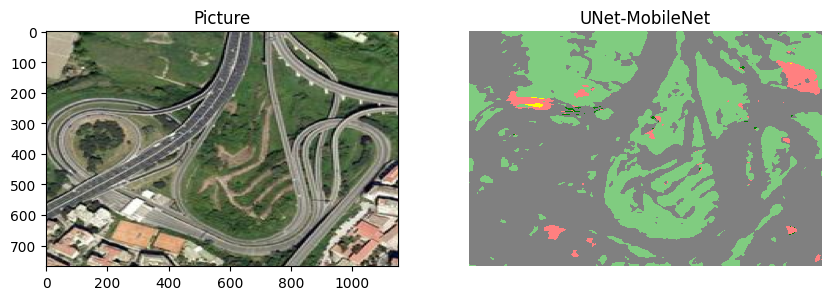

In [50]:
# Afficher une prédiction

tmp_test = ['/content/drive/MyDrive/Classroom/MSV/dataset RSICD/images/viaduct_93.jpg']
test_set = DatasetRSCID(tmp_test, transform=t_test)

pred_mask = predict_image_mask_miou(model, test_set[0])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(test_set[0])

ax1.set_title('Picture');
ax2.imshow(pred_mask)
ax2.imshow(pred_mask, cmap=cmap, interpolation='none')
ax2.set_title('UNet-MobileNet')
ax2.set_axis_off()